# TOPIC : 흉부 X-ray 정상/코로나/폐렴을 분류하는 Image Classification
### DATE : 2022-09-05
### ENV : (Window) CUDA 11.3

## LIBRARY

In [1]:
import os
import copy
import random

import cv2
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ipywidgets import interact

random_seed = 2022

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## DATA OVERVIEW

In [2]:
# 이미지 파일경로 불러오기
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]

    image_files = []
    images_dir = os.path.join(data_dir, sub_dir).replace("\\","/")
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path).replace("\\","/"))
    return image_files

# 이미지 파일 RGB 배열로 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name).replace("\\","/")
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## SETUP

In [3]:
data_dir = "../data/xray/train/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

normals_list = list_image_files(data_dir, class_list[0])
covids_list = list_image_files(data_dir, class_list[1])
pneumonias_list = list_image_files(data_dir, class_list[2])

In [4]:
print(os.path.join(data_dir, normals_list[0]))

../data/xray/train/Normal/01.jpeg


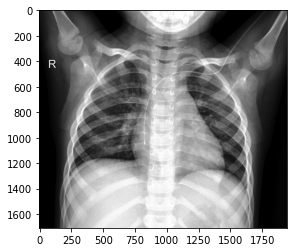

In [5]:
image = cv2.imread(os.path.join(data_dir, normals_list[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## VALIDATE IMAGE FILES

In [6]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

#@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])

    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

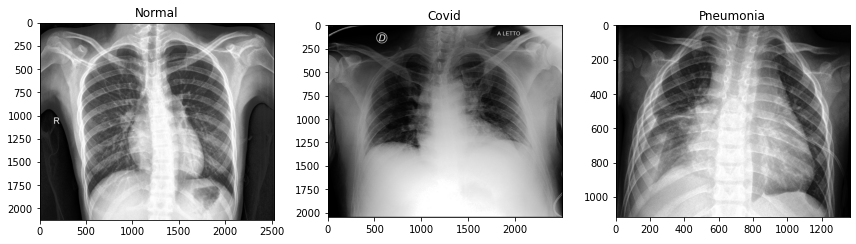

In [7]:
show_samples(2)

## DATASET CLASS

In [8]:
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, "Normal")
        covids = list_image_files(data_dir, "Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")

        self.files_path = normals + covids + pneumonias
        self.transform = transform

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = class_list.index(os.path.normpath(self.files_path[index]).split(os.sep)[0])
        '''
        MAC : target = class_list.index(self.files_path[index].split(os.sep)[0])
        '''

        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()

        return {"image":image, "target":target}

In [9]:
print('../data/xray/train/')
dset = Chest_dataset(data_dir)

../data/xray/train/


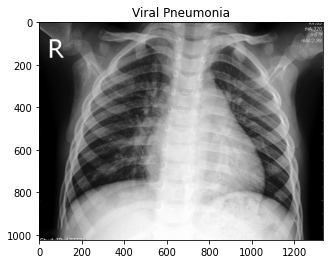

In [10]:
index = 200
plt.title(class_list[dset[index]["target"]])
plt.imshow(dset[index]["image"])

## TENSOR CONVERSION
### ["target"]은 class_list의 Index


In [11]:
# Tensor
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Dataset
dset = Chest_dataset(data_dir)
train_dset = Chest_dataset(data_dir, transformer)

# image, label
index = 100

raw_image = dset[index]["image"]
raw_label = dset[index]["target"]

image = train_dset[index]["image"]
label = train_dset[index]["target"]

In [12]:
print('raw image shape : ', raw_image.shape)
print('raw label : ', raw_label)

print('tensor image shape : ', image.shape)
print('tensor label : ', label)

raw image shape :  (1779, 1800, 3)
raw label :  1
tensor image shape :  torch.Size([3, 224, 224])
tensor label :  tensor([1])


## DATALOADER

In [13]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders["train"] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders["val"] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [14]:
train_data_dir = "../data/xray/train/"
val_data_dir = "../data/xray/test/"
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [15]:
for i, d in enumerate(dataloaders["train"]):
    if i == 0:
        break

In [16]:
print(d["target"].shape)
print(d["target"])

torch.Size([4, 1])
tensor([[1],
        [2],
        [2],
        [1]])


# ---

## LOAD VGG19 CLASSIFICATION MODEL

In [17]:
from torchsummary import summary
model = models.vgg19(pretrained=True)

C:\Users\pjm98\PycharmProjects\pytorch_image\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\pjm98\PycharmProjects\pytorch_image\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
summary(model, (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [19]:
summary(model, (3, 224, 224), batch_size=4, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 224, 224]           1,792
              ReLU-2          [4, 64, 224, 224]               0
            Conv2d-3          [4, 64, 224, 224]          36,928
              ReLU-4          [4, 64, 224, 224]               0
         MaxPool2d-5          [4, 64, 112, 112]               0
            Conv2d-6         [4, 128, 112, 112]          73,856
              ReLU-7         [4, 128, 112, 112]               0
            Conv2d-8         [4, 128, 112, 112]         147,584
              ReLU-9         [4, 128, 112, 112]               0
        MaxPool2d-10           [4, 128, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]         295,168
             ReLU-12           [4, 256, 56, 56]               0
           Conv2d-13           [4, 256, 56, 56]         590,080
             ReLU-14           [4, 256,

## VGG19 MODEL TUNNING

In [20]:
def build_vgg19_based_model(device_name='cuda'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [21]:
model = build_vgg19_based_model(device_name='cuda')

In [22]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# ---

## LOSS FUNCTION

In [23]:
loss_func = nn.CrossEntropyLoss(reduction="mean")

## GRADIENT OPTIMIZATION

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

## MODEL ACCURACY

In [25]:
@torch.no_grad() # Do not bring weight to backward
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

## CREATE TRAINING FUNCTION

In [26]:
device = torch.device("cuda")
print(device)
print(torch.__version__)
print(torch.cuda.is_available())

cuda
1.12.1+cu113
True


In [27]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    for phase in ["train", "val"]:
        
        running_loss = 0.0
        running_correct = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            image = batch["image"].to(device)
            target = batch["target"].squeeze(1).to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders[phase])} - Running Loss: {loss.item()}")

        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

def save_best_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

## RUN EPOCH IN TRAINING

In [28]:
num_epochs = 20

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")
    
    if (epoch > 3) and (accuracies["val"] > best_acc):
        best_acc = accuracies["val"]
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f"model_{epoch+1:02d}.pth")
        
print(f"Best Accuracy: {best_acc}")

0/62 - Running Loss: 1.1075516939163208
10/62 - Running Loss: 1.109103798866272
20/62 - Running Loss: 1.0948346853256226
30/62 - Running Loss: 1.0844740867614746
40/62 - Running Loss: 1.0866856575012207
50/62 - Running Loss: 0.9602077007293701
60/62 - Running Loss: 1.0765475034713745
1/20-Train Loss: 1.0807266206510606, Val Loss: 1.0004242234157794
1/20-Train Acc: 0.4032258064516129, Val Acc: 0.4393939393939394
0/62 - Running Loss: 1.0703339576721191
10/62 - Running Loss: 0.9314974546432495
20/62 - Running Loss: 0.8236327171325684
30/62 - Running Loss: 0.7890727519989014
40/62 - Running Loss: 1.1917136907577515
50/62 - Running Loss: 0.8496600389480591
60/62 - Running Loss: 0.7586740851402283
2/20-Train Loss: 0.9256450495412273, Val Loss: 0.8168499307198958
2/20-Train Acc: 0.6895161290322581, Val Acc: 0.7424242424242424
0/62 - Running Loss: 0.7253572344779968
10/62 - Running Loss: 0.8928929567337036
20/62 - Running Loss: 0.7018870115280151
30/62 - Running Loss: 0.8952029347419739
40/62 

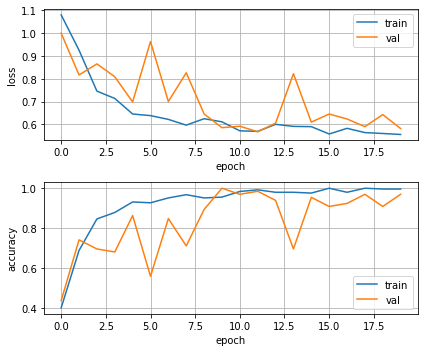

In [29]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

## PREDICT TEST IMAGE

In [30]:
test_data = "../data/xray/test/"

test_normals_list = list_image_files(data_dir, "Normal")
test_covids_list = list_image_files(data_dir, "Covid")
test_pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [31]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 244)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ])
    '''
    * Reference : https://jimmy-ai.tistory.com/110
    * Normalized Tensor : (Chanel, H, W)
    * Unsqueeze Dummy Value: (Batch, C, H, W)
        - Create one more dimension
    '''
    tensor_image = transformer(image)  # (C, H, W)
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W)
    return tensor_image

@torch.no_grad() # Backward Weight
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)

    _, pred_label = torch.max(prediction.detach().cpu(), dim=1) # (B, NUM_CLASSES)
    pred_label = pred_label.squeeze(0) # (B, 1) -> (1)
    return pred_label.item() # Torch Value Only

In [35]:
ckpt = torch.load("./trained_model/model_10.pth")

model = build_vgg19_based_model(device_name='cpu')
model.load_state_dict(ckpt)
model.eval()

C:\Users\pjm98\PycharmProjects\pytorch_image\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\pjm98\PycharmProjects\pytorch_image\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

#@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[prediction_1]} | GT:Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title(f"Pred:{class_list[prediction_2]} | GT:Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title(f"Pred:{class_list[prediction_3]} | GT:Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

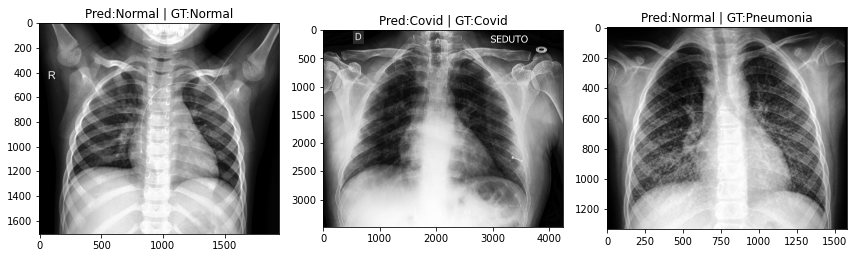

In [37]:
show_result(0)